In [10]:
import os

# 导入必要库
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind

from Constants import Constants as const

In [4]:
df = pd.read_stata(os.path.join(const.RESULT_PATH, '20250307_stock_act_data_v2.dta'))

In [40]:
# 第一步：设置处理变量 (T)
df['T'] = df['MajorGovCustomer']

# 第二步：估计倾向得分 (Propensity Score)
X = df[['log_market_value_w', 'lev_w', 'BM_w', 'ROA_w']]
X = sm.add_constant(X)  # 添加截距项
y = df['T']

# 使用logit回归
logit_model = sm.Probit(y, X)
result = logit_model.fit()
df['propensity_score'] = result.predict(X)

Optimization terminated successfully.
         Current function value: 0.425524
         Iterations 5


In [49]:
# 第三步：最近邻匹配（无重复匹配）

# 分为处理组和对照组
T_group = df[df['T'] == 1].copy()
C_group = df[df['T'] == 0].copy()

matched_indices = []

for idx, row in T_group.iterrows():
    c_idx = (C_group['propensity_score'] - row['propensity_score']).abs().idxmin()
    matched_indices.append((idx, c_idx))
    C_group = C_group.drop(c_idx)

T_matched = T_group.loc[[i[0] for i in matched_indices]]
C_matched = df.loc[[i[1] for i in matched_indices]]
df_matched = pd.concat([T_matched, C_matched]).copy()

In [28]:
# 第四步：检查匹配前后的变量均值差异与显著性，并展示匹配后样本量
def check_balance(df_before, df_after, variables):
    balance_table = pd.DataFrame(columns=['Before Diff', 'Before t-stat', 'After Diff', 'After t-stat'], index=variables)

    for var in variables:
        # 匹配前差异与t检验
        treat_before = df_before[df_before['T']==1][var]
        control_before = df_before[df_before['T']==0][var]
        before_diff = treat_before.mean() - control_before.mean()
        before_tstat, _ = ttest_ind(treat_before, control_before, equal_var=False)

        # 匹配后差异与t检验
        treat_after = df_after[df_after['T']==1][var]
        control_after = df_after[df_after['T']==0][var]
        after_diff = treat_after.mean() - control_after.mean()
        after_tstat, _ = ttest_ind(treat_after, control_after, equal_var=False)

        balance_table.loc[var] = [before_diff, before_tstat, after_diff, after_tstat]

    # 显示匹配后的样本量
    print(f"匹配后样本数: {len(df_after)}")

    return balance_table

In [42]:
df_matched.to_stata(os.path.join(const.RESULT_PATH, '20250314_stock_act_psm_data_v1.dta'), write_index=False, version=119)

In [52]:
df.loc[:, 'is_psm'] = 0
df.loc[df_matched.index, 'is_psm'] = 1

In [53]:
df.to_stata(os.path.join(const.RESULT_PATH, '20250314_stock_act_psm_data_v2.dta'), write_index=False, version=119)


In [51]:
df_matched[df_matched[[const.GVKEY, const.YEAR]].duplicated()]

,gvkey,fiscal_year,mf_indicator,frequency,log_frequency,MajorGovCustomer,post,log_market_value,lev,ROA,...,PEG_an,JLR,LPV,CER,FF6,QFM,permno,T,propensity_score,is_psm


In [50]:
# 4. 平衡性检验
# 比较匹配前后变量差异
def check_balance(data, title):
    treated = data[data['T'] == 1]
    control = data[data['T'] == 0]

    print(f"\n{title}平衡性检验:")
    for var in ['log_market_value_w', 'lev_w', 'BM_w', 'ROA_w']:
        t_mean = treated[var].mean()
        c_mean = control[var].mean()
        std_diff = (t_mean - c_mean)/treated[var].std()
        print(f"{var}: 标准化差异 = {std_diff:.4f}")

# 匹配前检验
check_balance(df, "原始数据")

# 匹配后检验
check_balance(df_matched, "匹配后数据")



原始数据平衡性检验:
log_market_value_w: 标准化差异 = -0.0498
lev_w: 标准化差异 = 0.1480
BM_w: 标准化差异 = 0.0591
ROA_w: 标准化差异 = 0.1156

匹配后数据平衡性检验:
log_market_value_w: 标准化差异 = 0.0226
lev_w: 标准化差异 = -0.0013
BM_w: 标准化差异 = -0.0294
ROA_w: 标准化差异 = 0.0276


D:\Users\wangy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20542 (\N{CJK UNIFIED IDEOGRAPH-503E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\wangy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\wangy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\wangy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Users\wangy\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_

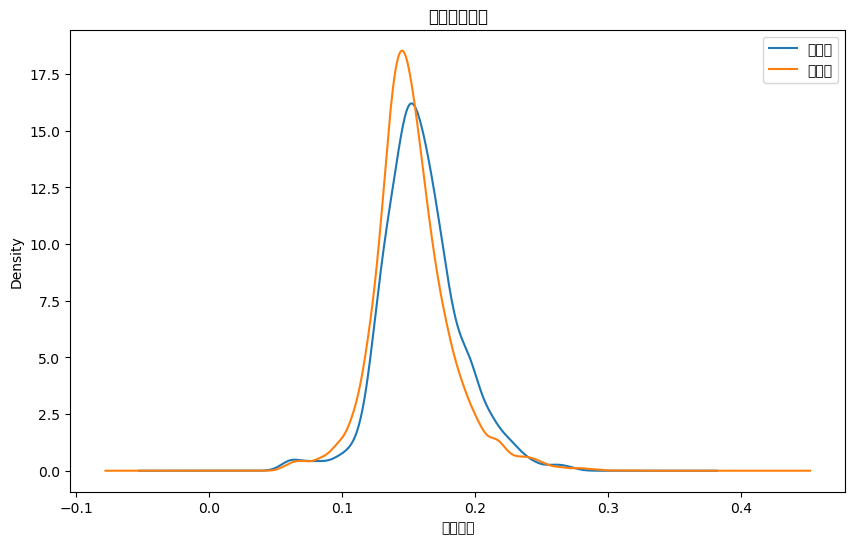

In [44]:
# 可选：绘制倾向得分分布图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df[df['T']==1]['propensity_score'].plot(kind='kde', label='处理组')
df[df['T']==0]['propensity_score'].plot(kind='kde', label='对照组')
plt.title('倾向得分分布')
plt.xlabel('倾向得分')
plt.legend()
plt.show()